# Document Clustering with LLM Embeddings

## Assignment Part G

This notebook demonstrates document clustering using state-of-the-art LLM embeddings and transformer models.

### What is Document Clustering?
Document clustering groups similar text documents together based on their semantic content. Applications include:
- Topic discovery and modeling
- News article categorization
- Customer feedback analysis
- Research paper organization
- Search result grouping

### Modern Approach with LLM Embeddings:
We'll use:
1. **Sentence Transformers**: State-of-the-art embeddings for semantic similarity
2. **BERT-based models**: Contextual embeddings
3. **OpenAI embeddings**: (optional) Latest embedding models

### Why LLM Embeddings?
- Capture semantic meaning, not just keywords
- Pre-trained on massive text corpora
- Transfer learning benefits
- Better than traditional TF-IDF or Word2Vec for many tasks

## 1. Installation and Setup

In [1]:
# Install required libraries
!pip install sentence-transformers -q
!pip install transformers -q
!pip install umap-learn -q
!pip install scikit-learn pandas numpy matplotlib seaborn -q
!pip install plotly -q
!pip install datasets -q  # For loading sample datasets

print("Installation complete!")

Installation complete!


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Sentence Transformers
from sentence_transformers import SentenceTransformer

# Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

# Dimensionality reduction
import umap

# For loading datasets
from datasets import load_dataset

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Document Dataset

We'll use the 20 Newsgroups dataset, a classic text classification dataset.

In [3]:
# Load 20 Newsgroups dataset from sklearn
from sklearn.datasets import fetch_20newsgroups

print("Loading 20 Newsgroups dataset...\n")

# Select a subset of categories for faster processing
categories = [
    'comp.graphics',
    'comp.sys.mac.hardware',
    'rec.autos',
    'rec.motorcycles',
    'sci.space',
    'sci.med',
    'talk.politics.guns',
    'talk.politics.mideast'
]

# Load dataset
newsgroups = fetch_20newsgroups(
    subset='all',
    categories=categories,
    remove=('headers', 'footers', 'quotes'),
    shuffle=True,
    random_state=42
)

# Sample subset for computational efficiency (500 documents)
n_samples = 500
indices = np.random.RandomState(42).choice(len(newsgroups.data), n_samples, replace=False)

documents = [newsgroups.data[i] for i in indices]
true_labels = [newsgroups.target[i] for i in indices]
category_names = [newsgroups.target_names[label] for label in true_labels]

# Create DataFrame
df_docs = pd.DataFrame({
    'document': documents,
    'true_category': category_names,
    'true_label': true_labels
})

# Clean documents (remove very short ones)
df_docs = df_docs[df_docs['document'].str.len() > 100].reset_index(drop=True)

print(f"Dataset loaded successfully!")
print(f"Number of documents: {len(df_docs)}")
print(f"Number of categories: {len(df_docs['true_category'].unique())}")
print(f"\nCategory distribution:")
print(df_docs['true_category'].value_counts())

print("\nSample documents:")
for i in range(3):
    print(f"\n{'='*80}")
    print(f"Category: {df_docs.iloc[i]['true_category']}")
    print(f"Document: {df_docs.iloc[i]['document'][:300]}...")
    print(f"{'='*80}")

Loading 20 Newsgroups dataset...

Dataset loaded successfully!
Number of documents: 457
Number of categories: 8

Category distribution:
true_category
comp.sys.mac.hardware    62
sci.space                60
talk.politics.guns       59
talk.politics.mideast    58
comp.graphics            56
rec.autos                56
rec.motorcycles          55
sci.med                  51
Name: count, dtype: int64

Sample documents:

Category: rec.motorcycles
Document: 
: >Hello DoD'ers et al.,

: >I need some advice on inner tubes in tubeless tyres. 
: >       Barry Manor DoD# 620

: Spend the bucks and get a new tire. 

:  ----===== DoD #8177 = Technician(Dr. Speed) .NOT. Student =====----


I second the commend from Dr. Speed, get a new tire.  It's like your
br...

Category: comp.sys.mac.hardware
Document: We have a Quadra 700 with 170MB HD, but need to a lot of sound sampling
for auditory research. What would be the best type of removable media for 
storing these audio clips?        

Ron
...

Categ

## 3. Generate LLM Embeddings

We'll use Sentence Transformers to create semantic embeddings of our documents.

In [4]:
# Load pre-trained sentence transformer model
print("Loading Sentence Transformer model...\n")

# We'll use 'all-MiniLM-L6-v2' - a good balance of speed and quality
# Other options:
# - 'all-mpnet-base-v2': Higher quality, slower
# - 'paraphrase-MiniLM-L3-v2': Faster, lower quality

model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

print(f"Model loaded: {model_name}")
print(f"Embedding dimension: {model.get_sentence_embedding_dimension()}")

Loading Sentence Transformer model...



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded: all-MiniLM-L6-v2
Embedding dimension: 384


In [5]:
# Generate embeddings for all documents
print("Generating embeddings for documents...\n")
print("This may take a few minutes depending on the number of documents...\n")

# Encode documents in batches for efficiency
batch_size = 32
embeddings = model.encode(
    df_docs['document'].tolist(),
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_numpy=True
)

print(f"\nEmbeddings generated successfully!")
print(f"Embeddings shape: {embeddings.shape}")
print(f"(Documents: {embeddings.shape[0]}, Dimensions: {embeddings.shape[1]})")

Generating embeddings for documents...

This may take a few minutes depending on the number of documents...



Batches:   0%|          | 0/15 [00:00<?, ?it/s]


Embeddings generated successfully!
Embeddings shape: (457, 384)
(Documents: 457, Dimensions: 384)


## 4. Visualize Embeddings

In [6]:
# Reduce dimensions for visualization
print("Reducing dimensions for visualization...\n")

# PCA
pca = PCA(n_components=50, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)
print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# t-SNE
print("\nApplying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

# UMAP
print("Applying UMAP...")
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embeddings_umap = umap_reducer.fit_transform(embeddings)

print("\nDimensionality reduction complete!")

Reducing dimensions for visualization...

PCA explained variance: 59.81%

Applying t-SNE...
Applying UMAP...

Dimensionality reduction complete!


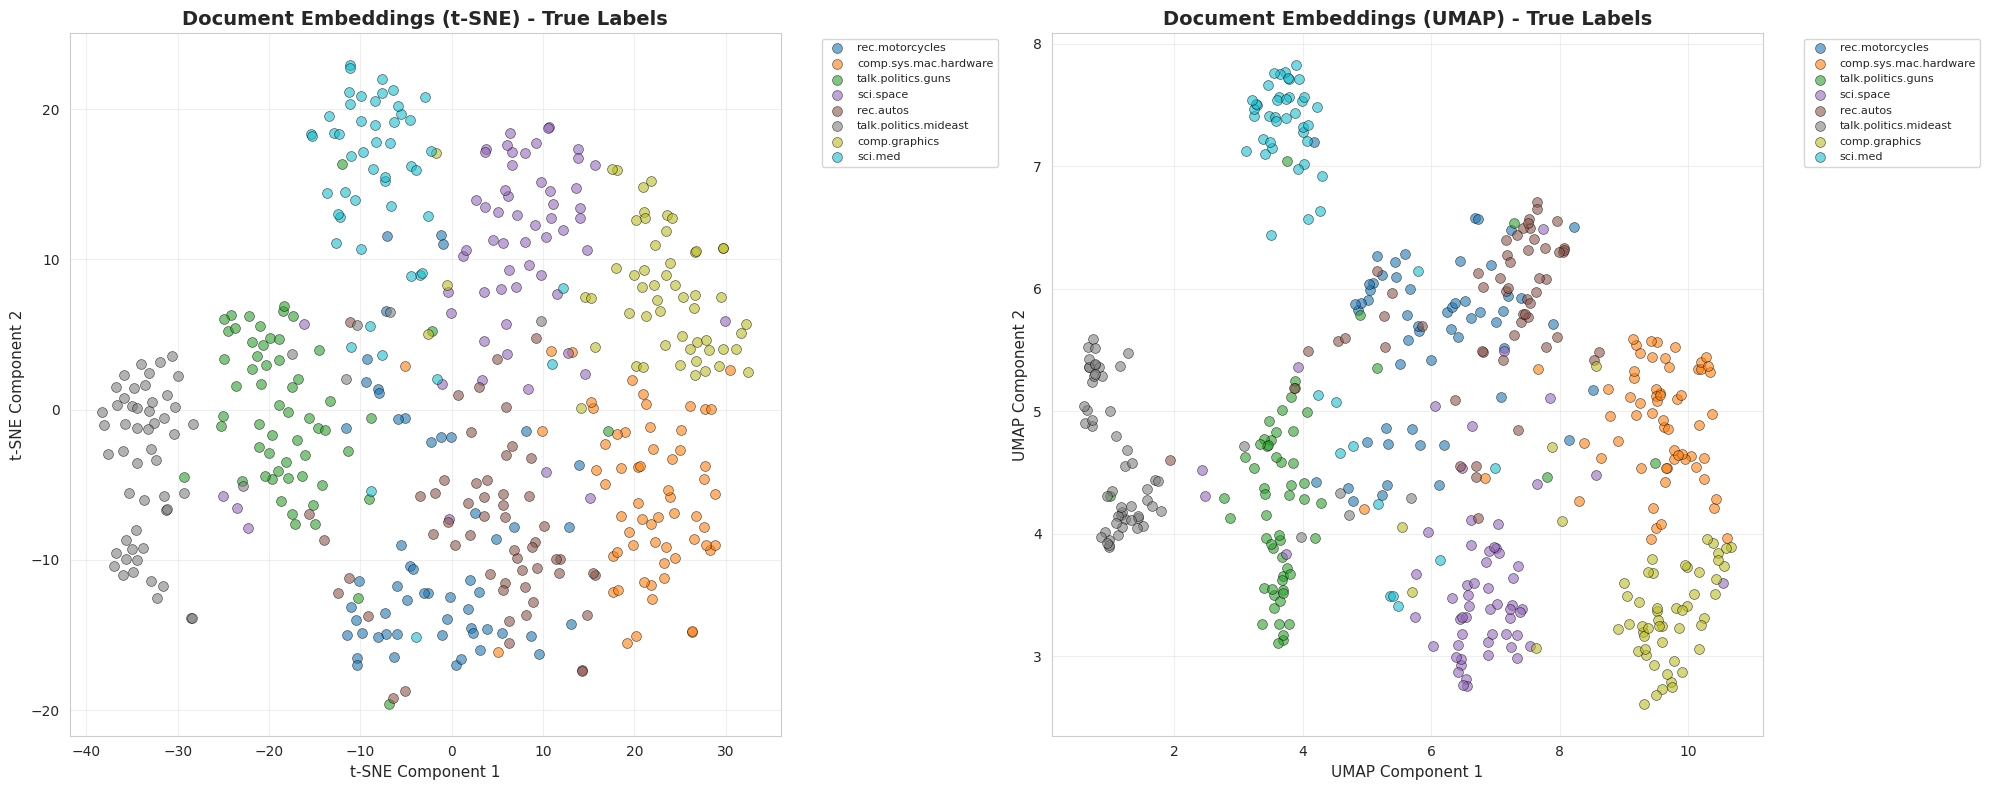

In [7]:
# Visualize embeddings with true labels
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Create color map for categories
unique_categories = df_docs['true_category'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_categories)))
category_colors = {cat: colors[i] for i, cat in enumerate(unique_categories)}
point_colors = [category_colors[cat] for cat in df_docs['true_category']]

# t-SNE plot
for category in unique_categories:
    mask = df_docs['true_category'] == category
    axes[0].scatter(
        embeddings_tsne[mask, 0],
        embeddings_tsne[mask, 1],
        c=[category_colors[category]],
        label=category,
        s=50,
        alpha=0.6,
        edgecolors='black',
        linewidth=0.5
    )

axes[0].set_title('Document Embeddings (t-SNE) - True Labels',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Component 1', fontsize=11)
axes[0].set_ylabel('t-SNE Component 2', fontsize=11)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0].grid(True, alpha=0.3)

# UMAP plot
for category in unique_categories:
    mask = df_docs['true_category'] == category
    axes[1].scatter(
        embeddings_umap[mask, 0],
        embeddings_umap[mask, 1],
        c=[category_colors[category]],
        label=category,
        s=50,
        alpha=0.6,
        edgecolors='black',
        linewidth=0.5
    )

axes[1].set_title('Document Embeddings (UMAP) - True Labels',
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('UMAP Component 1', fontsize=11)
axes[1].set_ylabel('UMAP Component 2', fontsize=11)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Document Clustering

In [8]:
# K-Means clustering
n_clusters = len(unique_categories)  # Use same number as true categories

print(f"Performing K-Means clustering with {n_clusters} clusters...\n")

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

# Add cluster labels to dataframe
df_docs['cluster'] = cluster_labels

print("Clustering complete!\n")
print("Cluster distribution:")
print(df_docs['cluster'].value_counts().sort_index())

Performing K-Means clustering with 8 clusters...

Clustering complete!

Cluster distribution:
cluster
0    59
1    54
2    72
3    51
4    49
5    69
6    62
7    41
Name: count, dtype: int64


In [9]:
# Evaluate clustering quality
print("Clustering Quality Metrics")
print("="*80)

silhouette = silhouette_score(embeddings, cluster_labels)
davies_bouldin = davies_bouldin_score(embeddings, cluster_labels)
calinski_harabasz = calinski_harabasz_score(embeddings, cluster_labels)

print(f"\nSilhouette Score: {silhouette:.4f}")
print("  → Range: [-1, 1], Higher is better")
print("  → Interpretation: How well-separated the clusters are")

print(f"\nDavies-Bouldin Index: {davies_bouldin:.4f}")
print("  → Range: [0, ∞], Lower is better")
print("  → Interpretation: Average similarity between clusters")

print(f"\nCalinski-Harabasz Score: {calinski_harabasz:.4f}")
print("  → Range: [0, ∞], Higher is better")
print("  → Interpretation: Ratio of between-cluster to within-cluster dispersion")

print("\n" + "="*80)

# Create metrics DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Score'],
    'Value': [silhouette, davies_bouldin, calinski_harabasz],
    'Interpretation': ['Higher is better', 'Lower is better', 'Higher is better']
})

display(metrics_df)

Clustering Quality Metrics

Silhouette Score: 0.0434
  → Range: [-1, 1], Higher is better
  → Interpretation: How well-separated the clusters are

Davies-Bouldin Index: 3.9061
  → Range: [0, ∞], Lower is better
  → Interpretation: Average similarity between clusters

Calinski-Harabasz Score: 10.5593
  → Range: [0, ∞], Higher is better
  → Interpretation: Ratio of between-cluster to within-cluster dispersion



,Metric,Value,Interpretation
0,Silhouette Score,0.043387,Higher is better
1,Davies-Bouldin Index,3.906131,Lower is better
2,Calinski-Harabasz Score,10.559348,Higher is better


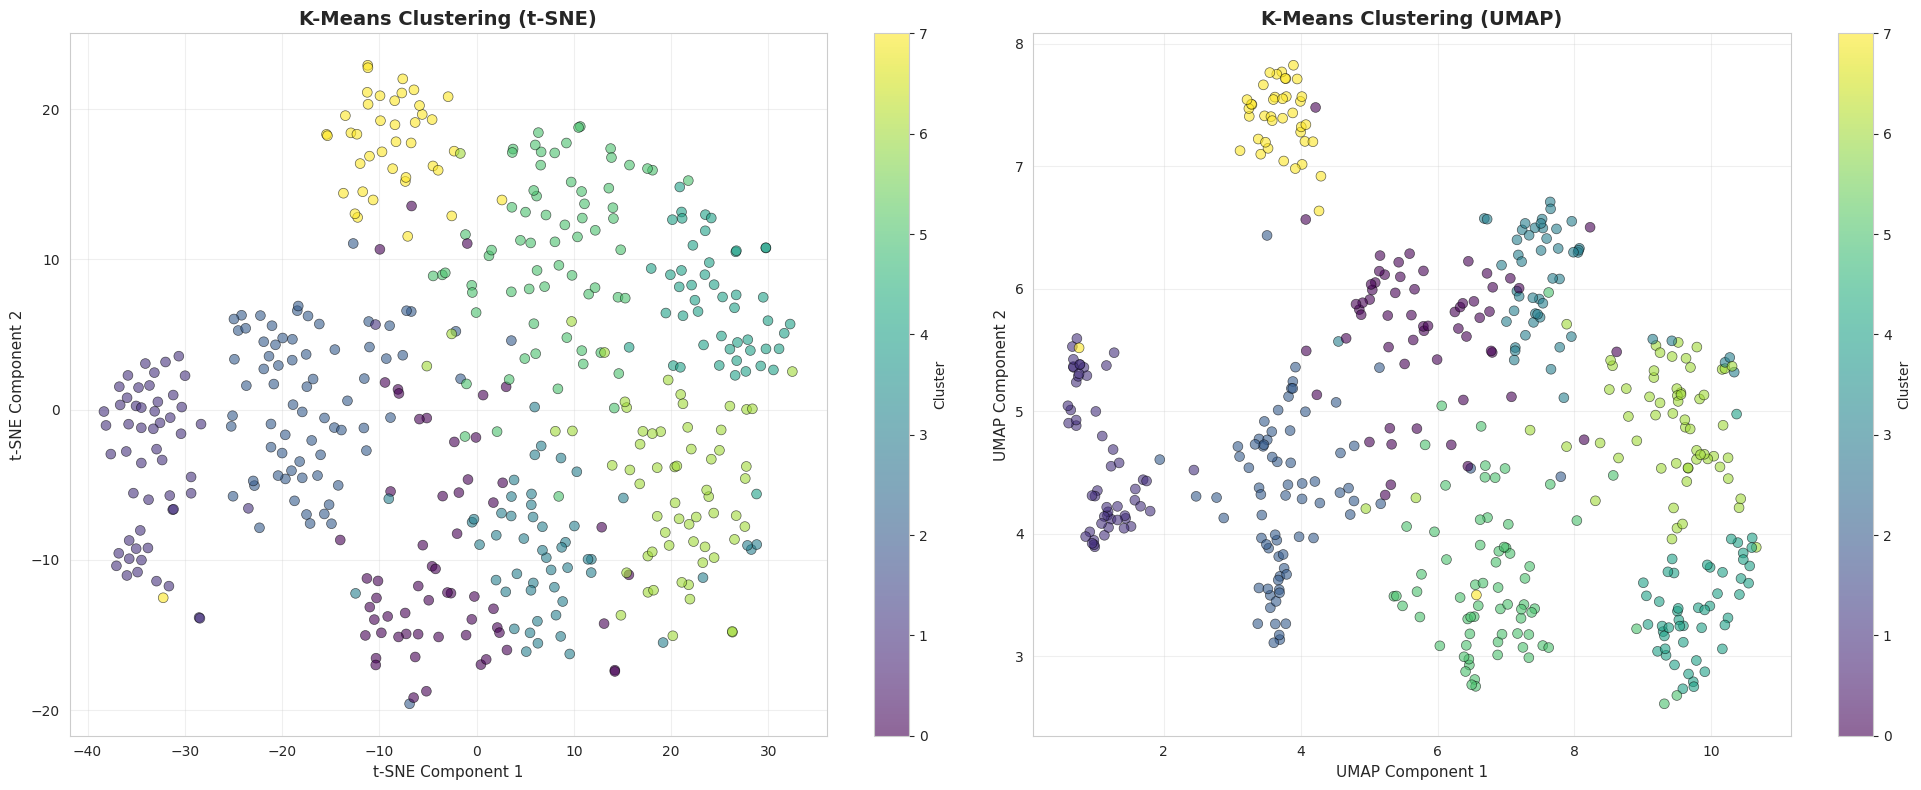

In [10]:
# Visualize clustering results
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# t-SNE with cluster labels
scatter1 = axes[0].scatter(
    embeddings_tsne[:, 0],
    embeddings_tsne[:, 1],
    c=cluster_labels,
    cmap='viridis',
    s=50,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
axes[0].set_title('K-Means Clustering (t-SNE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Component 1', fontsize=11)
axes[0].set_ylabel('t-SNE Component 2', fontsize=11)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')
axes[0].grid(True, alpha=0.3)

# UMAP with cluster labels
scatter2 = axes[1].scatter(
    embeddings_umap[:, 0],
    embeddings_umap[:, 1],
    c=cluster_labels,
    cmap='viridis',
    s=50,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
axes[1].set_title('K-Means Clustering (UMAP)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('UMAP Component 1', fontsize=11)
axes[1].set_ylabel('UMAP Component 2', fontsize=11)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Cluster Analysis and Interpretation

In [11]:
# Analyze each cluster
print("Cluster Analysis")
print("="*80)

for cluster_id in range(n_clusters):
    cluster_docs = df_docs[df_docs['cluster'] == cluster_id]

    print(f"\nCluster {cluster_id}:")
    print("-" * 80)
    print(f"Size: {len(cluster_docs)} documents")

    # Show true category distribution in this cluster
    print(f"\nTrue category distribution:")
    category_dist = cluster_docs['true_category'].value_counts()
    for category, count in category_dist.items():
        percentage = (count / len(cluster_docs)) * 100
        print(f"  {category}: {count} ({percentage:.1f}%)")

    # Show sample documents
    print(f"\nSample documents from Cluster {cluster_id}:")
    for i, (idx, row) in enumerate(cluster_docs.head(2).iterrows()):
        print(f"  {i+1}. [{row['true_category']}] {row['document'][:150]}...")

    print("-" * 80)

print("\n" + "="*80)

Cluster Analysis

Cluster 0:
--------------------------------------------------------------------------------
Size: 59 documents

True category distribution:
  rec.motorcycles: 38 (64.4%)
  rec.autos: 16 (27.1%)
  sci.med: 4 (6.8%)
  talk.politics.guns: 1 (1.7%)

Sample documents from Cluster 0:
  1. [rec.motorcycles] 
: >Hello DoD'ers et al.,

: >I need some advice on inner tubes in tubeless tyres. 
: >       Barry Manor DoD# 620

: Spend the bucks and get a new ti...
  2. [rec.autos] Dumbest options? Well here in the UK, BMW offer a 'no-smokers' option...
It just means they take the fag lighter out.... big deal....

BTW - I just bo...
--------------------------------------------------------------------------------

Cluster 1:
--------------------------------------------------------------------------------
Size: 54 documents

True category distribution:
  talk.politics.mideast: 52 (96.3%)
  talk.politics.guns: 1 (1.9%)
  sci.space: 1 (1.9%)

Sample documents from Cluster 1:
  1. [talk

In [12]:
# Calculate cluster purity
def calculate_purity(true_labels, cluster_labels):
    """
    Calculate clustering purity.
    Purity measures how well clusters correspond to true labels.
    """
    total = len(true_labels)
    correct = 0

    for cluster_id in np.unique(cluster_labels):
        cluster_mask = cluster_labels == cluster_id
        cluster_true_labels = true_labels[cluster_mask]

        # Most common true label in this cluster
        most_common = Counter(cluster_true_labels).most_common(1)[0][1]
        correct += most_common

    return correct / total

purity = calculate_purity(df_docs['true_label'].values, cluster_labels)

print(f"Cluster Purity: {purity:.4f}")
print(f"Interpretation: {purity*100:.2f}% of documents are in clusters with")
print(f"their majority true category.")
print(f"\nNote: Perfect purity (1.0) means each cluster contains only")
print(f"documents from a single true category.")

Cluster Purity: 0.7921
Interpretation: 79.21% of documents are in clusters with
their majority true category.

Note: Perfect purity (1.0) means each cluster contains only
documents from a single true category.



Contingency Table (Cluster vs True Category):


true_category,comp.graphics,comp.sys.mac.hardware,rec.autos,rec.motorcycles,sci.med,sci.space,talk.politics.guns,talk.politics.mideast,All
cluster,,,,,,,,,
0,0,0,16,38,4,0,1,0,59
1,0,0,0,0,0,1,1,52,54
2,0,0,2,3,5,4,54,4,72
3,0,6,32,9,0,3,1,0,51
4,46,2,0,0,0,1,0,0,49
5,7,1,4,2,5,50,0,0,69
6,3,53,2,2,0,0,1,1,62
7,0,0,0,1,37,1,1,1,41
All,56,62,56,55,51,60,59,58,457


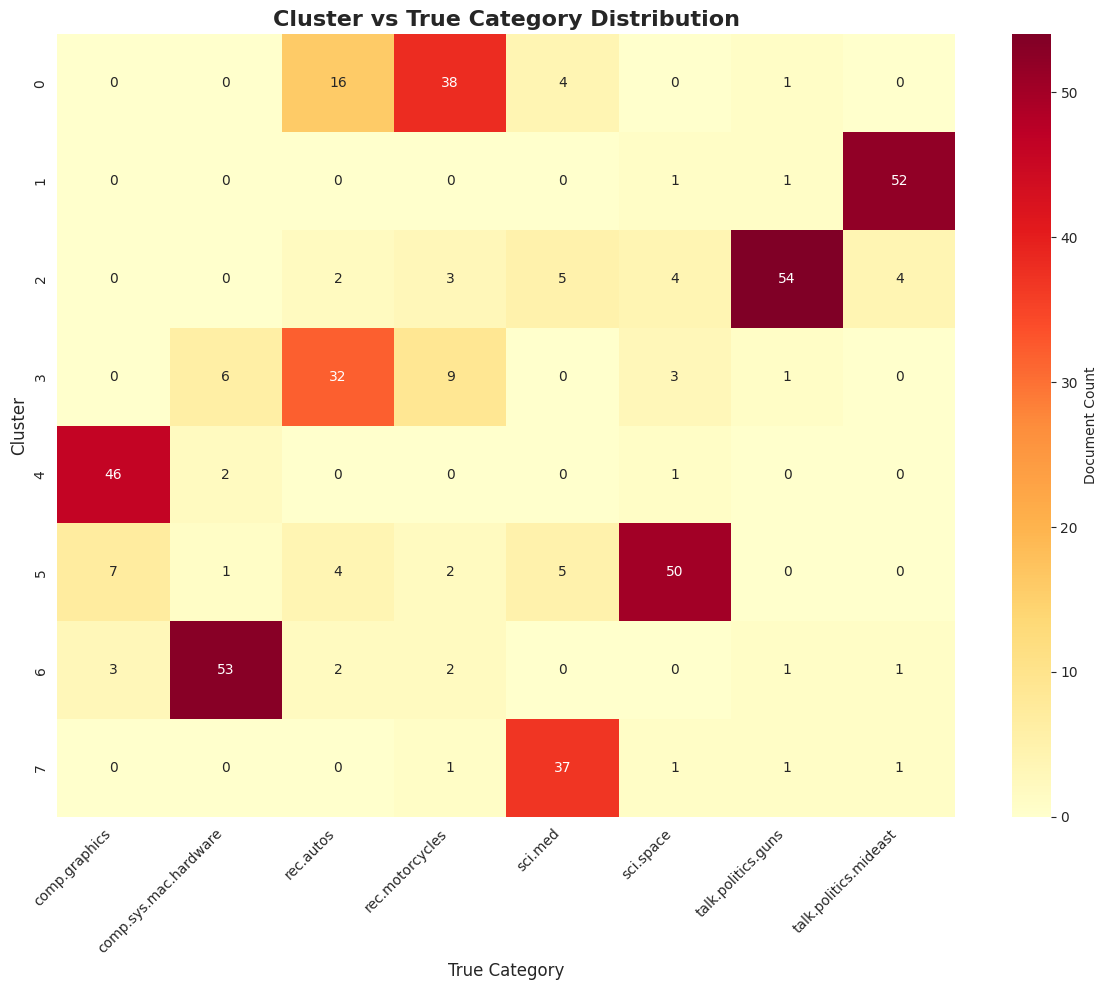

In [13]:
# Create confusion matrix between clusters and true categories
from sklearn.metrics import confusion_matrix

# Map clusters to most common true category
cluster_to_category = {}
for cluster_id in range(n_clusters):
    cluster_docs = df_docs[df_docs['cluster'] == cluster_id]
    most_common_category = cluster_docs['true_category'].value_counts().index[0]
    cluster_to_category[cluster_id] = most_common_category

# Create contingency table
contingency_table = pd.crosstab(
    df_docs['cluster'],
    df_docs['true_category'],
    margins=True
)

print("\nContingency Table (Cluster vs True Category):")
print("="*80)
display(contingency_table)

# Visualize as heatmap
plt.figure(figsize=(12, 10))
contingency_no_margins = contingency_table.iloc[:-1, :-1]
sns.heatmap(contingency_no_margins, annot=True, fmt='d', cmap='YlOrRd',
            cbar_kws={'label': 'Document Count'})
plt.title('Cluster vs True Category Distribution', fontsize=16, fontweight='bold')
plt.xlabel('True Category', fontsize=12)
plt.ylabel('Cluster', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 7. Alternative Clustering Methods

Performing DBSCAN clustering...

Number of clusters: 6
Number of noise points: 394 (86.21%)
Silhouette Score (excluding noise): 0.1580


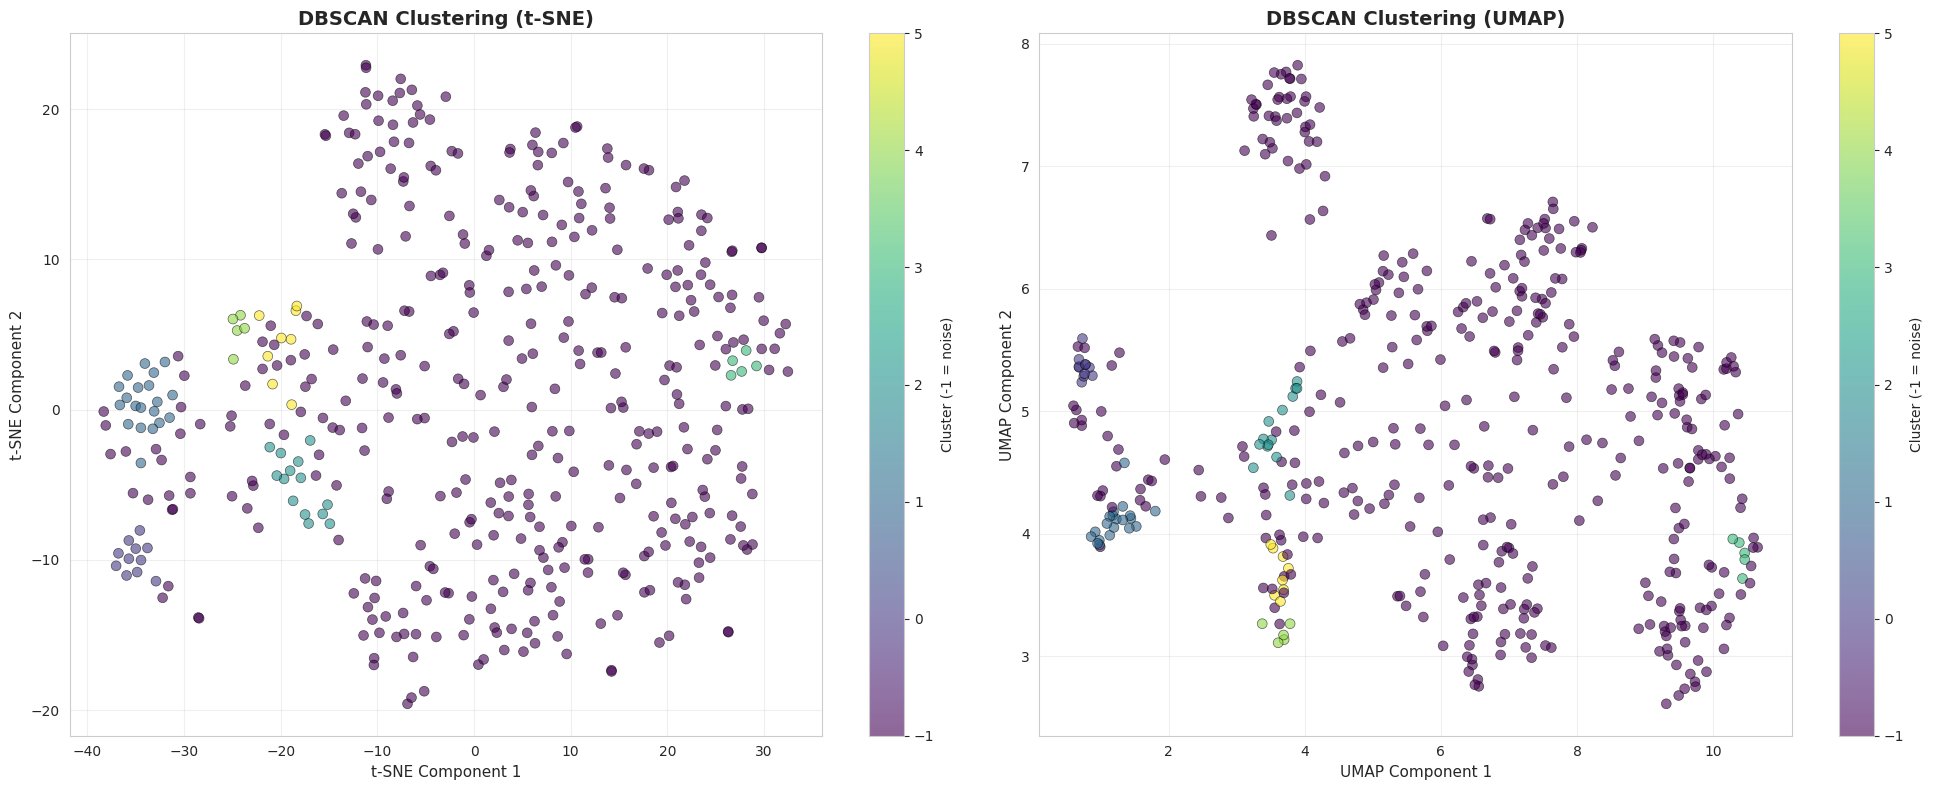

In [14]:
# DBSCAN clustering
print("Performing DBSCAN clustering...\n")

dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
dbscan_labels = dbscan.fit_predict(embeddings)

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Number of clusters: {n_clusters_dbscan}")
print(f"Number of noise points: {n_noise} ({n_noise/len(dbscan_labels)*100:.2f}%)")

if n_clusters_dbscan > 1:
    # Evaluate (excluding noise points)
    non_noise_mask = dbscan_labels != -1
    if sum(non_noise_mask) > 0:
        dbscan_silhouette = silhouette_score(
            embeddings[non_noise_mask],
            dbscan_labels[non_noise_mask]
        )
        print(f"Silhouette Score (excluding noise): {dbscan_silhouette:.4f}")

# Visualize DBSCAN results
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# t-SNE
scatter1 = axes[0].scatter(
    embeddings_tsne[:, 0],
    embeddings_tsne[:, 1],
    c=dbscan_labels,
    cmap='viridis',
    s=50,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
axes[0].set_title('DBSCAN Clustering (t-SNE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Component 1', fontsize=11)
axes[0].set_ylabel('t-SNE Component 2', fontsize=11)
plt.colorbar(scatter1, ax=axes[0], label='Cluster (-1 = noise)')
axes[0].grid(True, alpha=0.3)

# UMAP
scatter2 = axes[1].scatter(
    embeddings_umap[:, 0],
    embeddings_umap[:, 1],
    c=dbscan_labels,
    cmap='viridis',
    s=50,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
axes[1].set_title('DBSCAN Clustering (UMAP)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('UMAP Component 1', fontsize=11)
axes[1].set_ylabel('UMAP Component 2', fontsize=11)
plt.colorbar(scatter2, ax=axes[1], label='Cluster (-1 = noise)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Performing Hierarchical clustering...

Silhouette Score: 0.0372
Davies-Bouldin Index: 4.1431


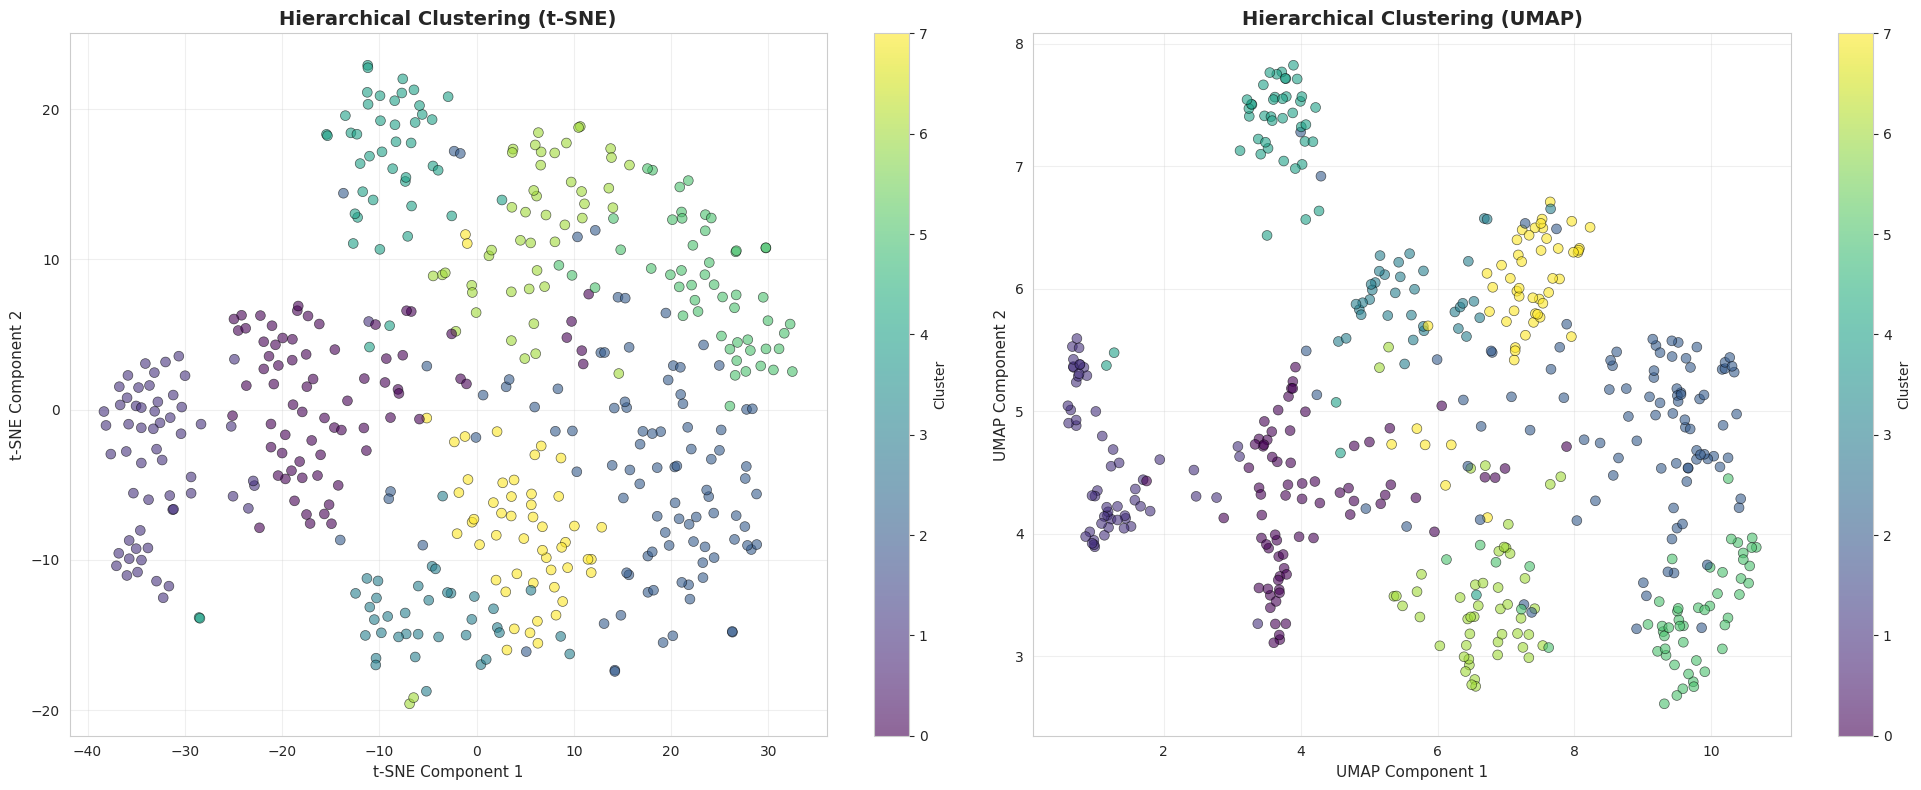

In [15]:
# Hierarchical clustering
print("Performing Hierarchical clustering...\n")

hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(embeddings)

# Evaluate
hier_silhouette = silhouette_score(embeddings, hierarchical_labels)
hier_davies = davies_bouldin_score(embeddings, hierarchical_labels)

print(f"Silhouette Score: {hier_silhouette:.4f}")
print(f"Davies-Bouldin Index: {hier_davies:.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

scatter1 = axes[0].scatter(
    embeddings_tsne[:, 0],
    embeddings_tsne[:, 1],
    c=hierarchical_labels,
    cmap='viridis',
    s=50,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
axes[0].set_title('Hierarchical Clustering (t-SNE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Component 1', fontsize=11)
axes[0].set_ylabel('t-SNE Component 2', fontsize=11)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')
axes[0].grid(True, alpha=0.3)

scatter2 = axes[1].scatter(
    embeddings_umap[:, 0],
    embeddings_umap[:, 1],
    c=hierarchical_labels,
    cmap='viridis',
    s=50,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
axes[1].set_title('Hierarchical Clustering (UMAP)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('UMAP Component 1', fontsize=11)
axes[1].set_ylabel('UMAP Component 2', fontsize=11)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Compare All Methods


Clustering Methods Comparison:


,Method,Silhouette,Davies-Bouldin,Calinski-Harabasz,Purity,N_Clusters
2,DBSCAN,0.157989,1.777987,7.030656,0.984127,6
0,K-Means,0.043387,3.906131,10.559348,0.792123,8
1,Hierarchical,0.037237,4.143134,9.701284,0.759300,8


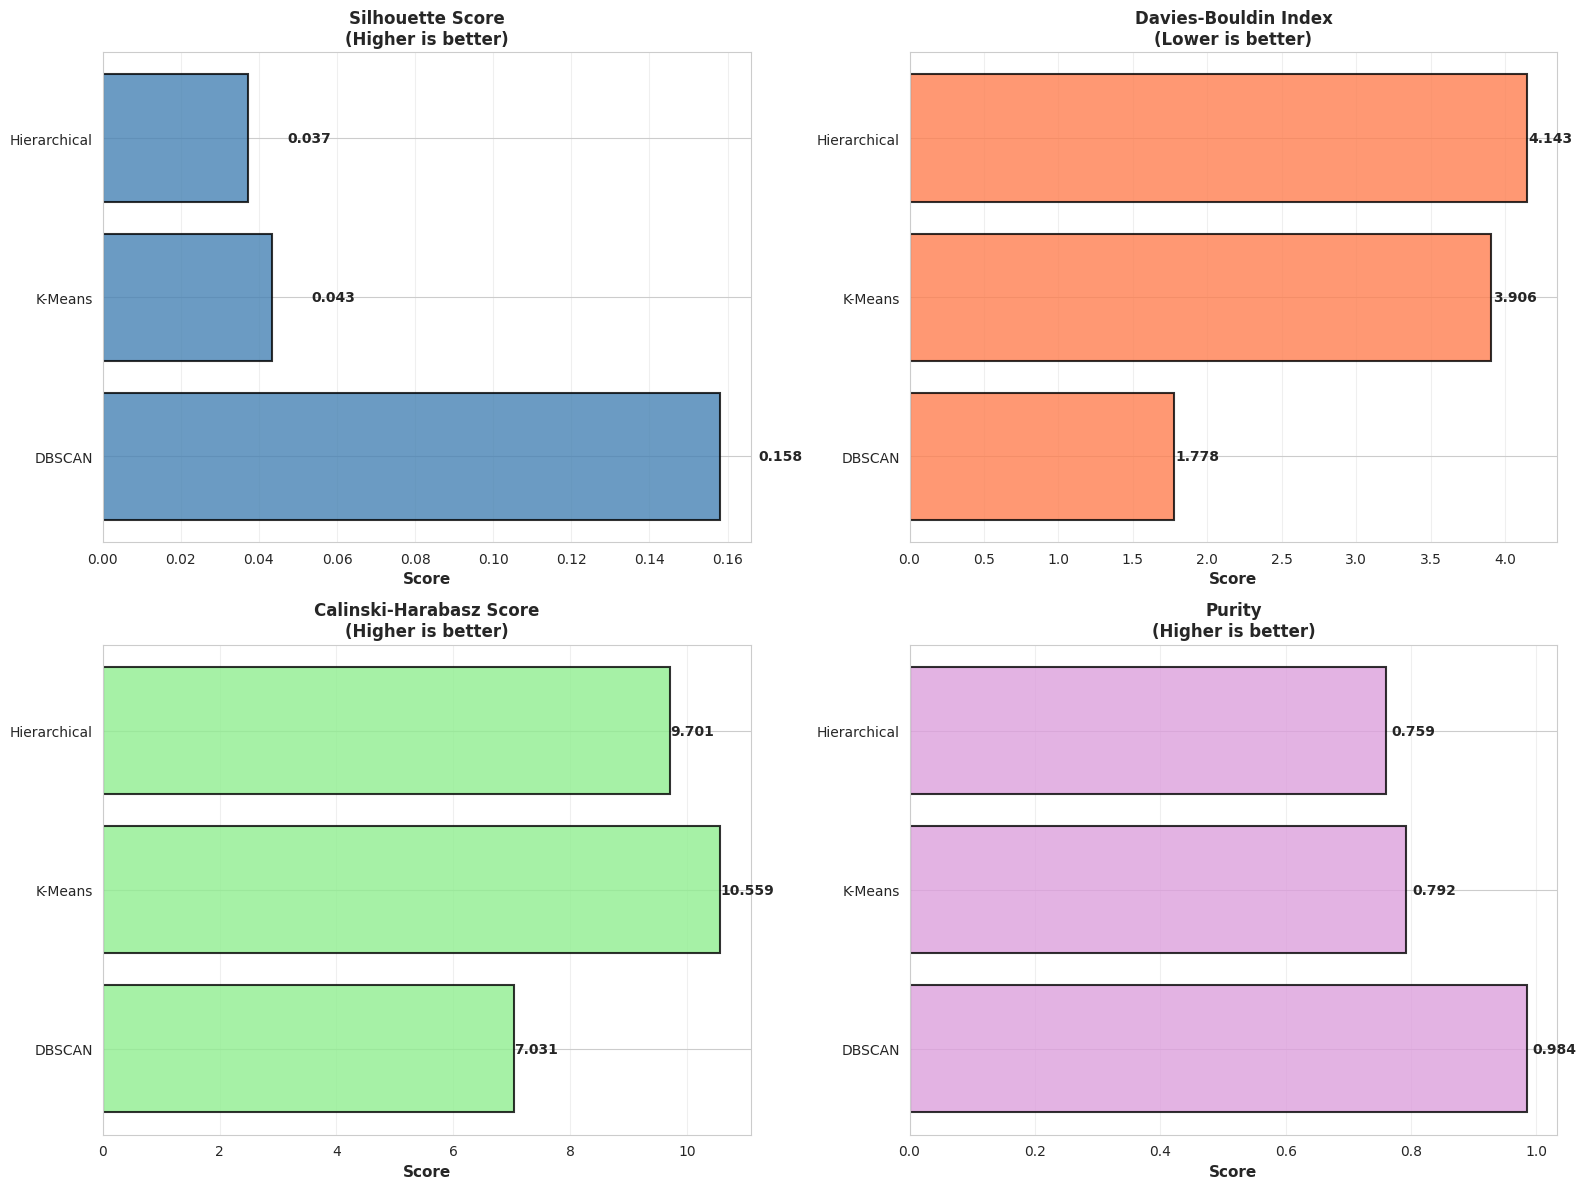

In [16]:
# Compare all clustering methods
comparison_data = [
    {
        'Method': 'K-Means',
        'Silhouette': silhouette,
        'Davies-Bouldin': davies_bouldin,
        'Calinski-Harabasz': calinski_harabasz,
        'Purity': purity,
        'N_Clusters': n_clusters
    },
    {
        'Method': 'Hierarchical',
        'Silhouette': hier_silhouette,
        'Davies-Bouldin': hier_davies,
        'Calinski-Harabasz': calinski_harabasz_score(embeddings, hierarchical_labels),
        'Purity': calculate_purity(df_docs['true_label'].values, hierarchical_labels),
        'N_Clusters': n_clusters
    }
]

if n_clusters_dbscan > 1 and sum(dbscan_labels != -1) > 0:
    non_noise_mask = dbscan_labels != -1
    comparison_data.append({
        'Method': 'DBSCAN',
        'Silhouette': silhouette_score(embeddings[non_noise_mask], dbscan_labels[non_noise_mask]),
        'Davies-Bouldin': davies_bouldin_score(embeddings[non_noise_mask], dbscan_labels[non_noise_mask]),
        'Calinski-Harabasz': calinski_harabasz_score(embeddings[non_noise_mask], dbscan_labels[non_noise_mask]),
        'Purity': calculate_purity(df_docs['true_label'].values[non_noise_mask], dbscan_labels[non_noise_mask]),
        'N_Clusters': n_clusters_dbscan
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Silhouette', ascending=False)

print("\nClustering Methods Comparison:")
print("="*80)
display(comparison_df)

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz', 'Purity']
titles = ['Silhouette Score\n(Higher is better)',
          'Davies-Bouldin Index\n(Lower is better)',
          'Calinski-Harabasz Score\n(Higher is better)',
          'Purity\n(Higher is better)']
colors_plot = ['steelblue', 'coral', 'lightgreen', 'plum']

for idx, (metric, title, color) in enumerate(zip(metrics, titles, colors_plot)):
    ax = axes[idx // 2, idx % 2]
    ax.barh(comparison_df['Method'], comparison_df[metric],
            color=color, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax.set_xlabel('Score', fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, v in enumerate(comparison_df[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Find Optimal Number of Clusters

Testing different numbers of clusters...

k= 2: Silhouette=0.0377, DB=4.4136
k= 3: Silhouette=0.0370, DB=4.9088
k= 4: Silhouette=0.0395, DB=4.8165
k= 5: Silhouette=0.0374, DB=4.4489
k= 6: Silhouette=0.0406, DB=4.2169
k= 7: Silhouette=0.0426, DB=4.0376
k= 8: Silhouette=0.0434, DB=3.9061
k= 9: Silhouette=0.0435, DB=3.8969
k=10: Silhouette=0.0422, DB=3.8817
k=11: Silhouette=0.0418, DB=3.7860
k=12: Silhouette=0.0440, DB=3.6534
k=13: Silhouette=0.0407, DB=3.6620
k=14: Silhouette=0.0401, DB=3.7332
k=15: Silhouette=0.0328, DB=3.6225


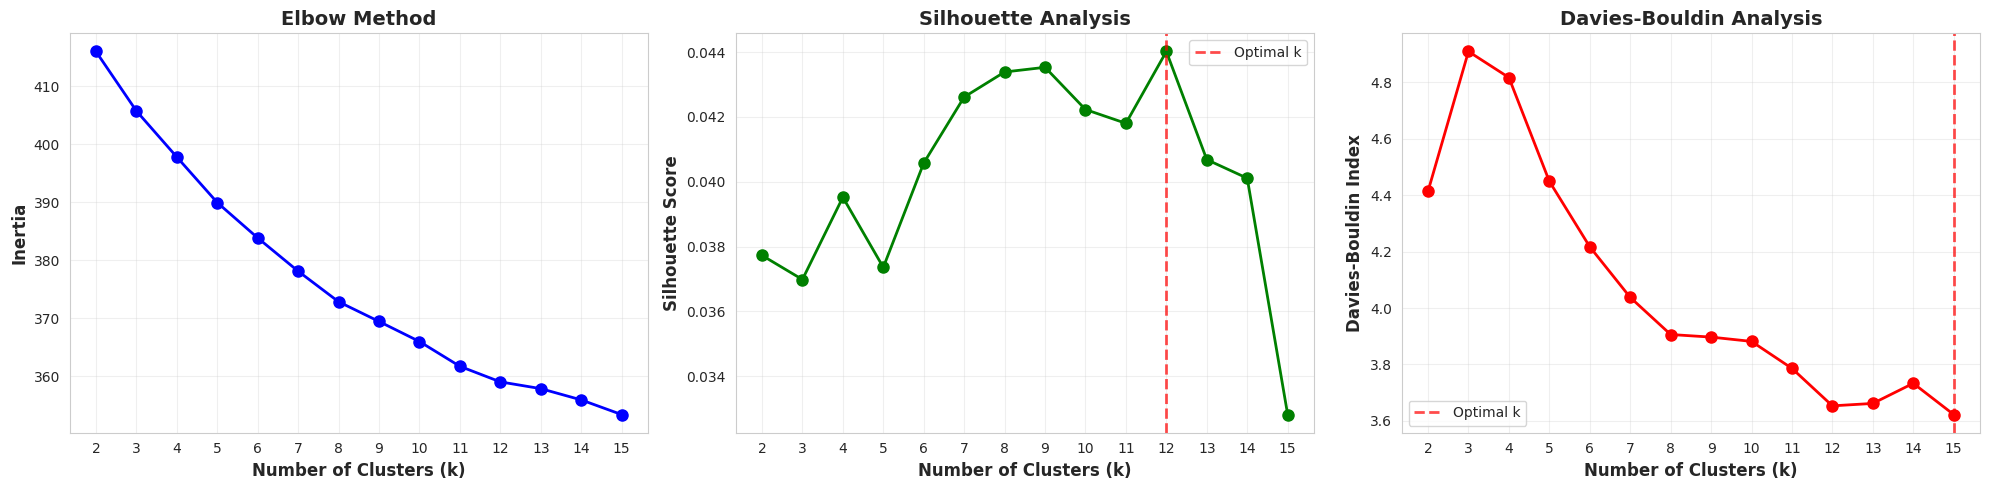


Optimal number of clusters:
  Based on Silhouette: k = 12
  Based on Davies-Bouldin: k = 15
  True number of categories: 8


In [17]:
# Test different numbers of clusters
k_range = range(2, 16)
inertias = []
silhouettes = []
davies_bouldins = []

print("Testing different numbers of clusters...\n")

for k in k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_test = kmeans_test.fit_predict(embeddings)

    inertias.append(kmeans_test.inertia_)
    silhouettes.append(silhouette_score(embeddings, labels_test))
    davies_bouldins.append(davies_bouldin_score(embeddings, labels_test))

    print(f"k={k:2d}: Silhouette={silhouettes[-1]:.4f}, DB={davies_bouldins[-1]:.4f}")

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

axes[1].plot(k_range, silhouettes, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)
axes[1].axvline(k_range[np.argmax(silhouettes)], color='red',
                linestyle='--', linewidth=2, alpha=0.7, label='Optimal k')
axes[1].legend()

axes[2].plot(k_range, davies_bouldins, 'ro-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Davies-Bouldin Index', fontsize=12, fontweight='bold')
axes[2].set_title('Davies-Bouldin Analysis', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(k_range)
axes[2].axvline(k_range[np.argmin(davies_bouldins)], color='red',
                linestyle='--', linewidth=2, alpha=0.7, label='Optimal k')
axes[2].legend()

plt.tight_layout()
plt.show()

optimal_k_sil = k_range[np.argmax(silhouettes)]
optimal_k_db = k_range[np.argmin(davies_bouldins)]

print(f"\nOptimal number of clusters:")
print(f"  Based on Silhouette: k = {optimal_k_sil}")
print(f"  Based on Davies-Bouldin: k = {optimal_k_db}")
print(f"  True number of categories: {len(unique_categories)}")

## 10. Conclusion and Best Practices

### Key Findings:

#### 1. LLM Embeddings for Document Clustering:
- **Advantages**:
  - Capture semantic meaning beyond keywords
  - Pre-trained on massive datasets (transfer learning)
  - Work out-of-the-box without extensive preprocessing
  - Handle synonyms, context, and nuance
  - Language-agnostic (multilingual models available)

- **Disadvantages**:
  - Computationally expensive for very large datasets
  - Require GPU for optimal performance
  - Black-box nature (less interpretable than TF-IDF)
  - May need fine-tuning for domain-specific tasks

#### 2. Model Selection:
- **all-MiniLM-L6-v2**: Fast, good balance (384 dims)
- **all-mpnet-base-v2**: Higher quality (768 dims)
- **paraphrase-multilingual**: For multilingual documents
- **Domain-specific**: Fine-tune for specialized domains

#### 3. Clustering Algorithm Selection:
- **K-Means**: Fast, works well when cluster count is known
- **DBSCAN**: Good for finding outliers, no need to specify k
- **Hierarchical**: Good for understanding cluster relationships
- **HDBSCAN**: Better than DBSCAN for varying density

#### 4. Dimensionality Reduction:
- **PCA**: Fast, linear, preserves global structure
- **t-SNE**: Better for visualization, non-linear
- **UMAP**: Best of both worlds, fast and preserves structure

### Best Practices:

#### 1. Data Preprocessing:
- Remove very short documents (< 50 chars)
- Clean HTML, special characters if needed
- Consider document segmentation for very long texts
- Handle duplicates appropriately

#### 2. Embedding Generation:
- Use batch processing for large datasets
- Normalize embeddings for cosine similarity
- Cache embeddings to avoid recomputation
- Consider dimensionality reduction for very large corpora

#### 3. Clustering:
- Try multiple algorithms and compare
- Use multiple evaluation metrics
- Validate with domain experts
- Consider hierarchical clustering for interpretability

#### 4. Evaluation:
- **Intrinsic metrics**: Silhouette, Davies-Bouldin, Calinski-Harabasz
- **Extrinsic metrics**: Purity, NMI, ARI (if labels available)
- **Qualitative**: Manual inspection of cluster contents
- **Business metrics**: Task-specific KPIs

### Practical Applications:

1. **News Aggregation**:
   - Group similar news articles
   - Detect trending topics
   - Reduce information overload

2. **Customer Feedback**:
   - Identify common issues
   - Prioritize improvements
   - Sentiment analysis by cluster

3. **Research Papers**:
   - Organize literature
   - Find related work
   - Identify research gaps

4. **E-commerce**:
   - Product categorization
   - Review analysis
   - Recommendation systems

### Advanced Techniques:

1. **Topic Modeling**:
   - BERTopic: Clustering + topic extraction
   - Top2Vec: Similar to BERTopic
   - CTM: Combined topic models

2. **Fine-tuning**:
   - Domain adaptation
   - Contrastive learning
   - Supervised clustering

3. **Ensemble Methods**:
   - Combine multiple embedding models
   - Consensus clustering
   - Weighted voting

### Tools and Libraries:

- **Sentence Transformers**: Best for embeddings
- **BERTopic**: Topic modeling with transformers
- **UMAP**: Fast dimensionality reduction
- **HDBSCAN**: Hierarchical DBSCAN
- **scikit-learn**: Classical clustering algorithms

### Performance Tips:

1. **Speed**:
   - Use smaller models for large datasets
   - Batch processing
   - GPU acceleration
   - Approximate nearest neighbors (FAISS, Annoy)

2. **Memory**:
   - Process in chunks
   - Use lower precision (float16)
   - Dimensionality reduction

3. **Quality**:
   - Use larger models when possible
   - Fine-tune for domain
   - Ensemble methods

### Next Steps:

1. Try BERTopic for topic modeling
2. Experiment with different embedding models
3. Fine-tune embeddings for your domain
4. Implement interactive cluster exploration
5. Build a production pipeline with caching